In [1]:
import numpy as np
from numpy.random import randn
from numpy.linalg import matrix_rank

# Python control toolbox: https://python-control.readthedocs.io/
from control import obsv, lqe, lqr, ss, use_numpy_matrix
from control.matlab import lsim
use_numpy_matrix(False)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

In [2]:
ndims = 4

m = 1   # mass of pendulum
M = 5   # mass of cart
L = 2   # length of pendulum
g = -10 # acceleration due to gravity (approx)
d = 1   # cart damping

b = -1 # pendulum down (b = -1)

# System matrices
A = np.array([
    [0,          1,                  0,  0],
    [0,       -d/M,            b*m*g/M,  0],
    [0,          0,                  0,  1],
    [0, -b*d/(M*L), -b*(m + M)*g/(M*L),  0]
])
B = np.array([[0, 1/M, 0, b/(M*L)]]).T

# Measure just cart position, x
C = np.array([[1, 0, 0, 0]])

print(f'Rank of observability matrix is {matrix_rank(obsv(A, C))}')

Rank of observability matrix is 4


In [3]:
# Disturbance and noise magnitude
V_d = np.identity(ndims)  # Covariance of disturbances
V_n = 1                   # Covariance of sensor noise
G = np.identity(ndims)    # Noise matrix

# Build Kalman filter (vector of gains) using linear quadratic estimation (lqe)
K_f, *_ = lqe(A, G, C, V_d, V_n)

# Alternatively, we can use linear quadratic regulator (lqr) of the dual system
K_f2, *_ = lqr(A.T, C.T, V_d, V_n)
K_f2 = K_f2.T
assert np.allclose(K_f, K_f2)

In [4]:
# Augment system with additional inputs
B_aug = np.hstack([B, np.eye(ndims), np.zeros_like(B)])
D_aug = np.array([0, 0, 0, 0, 0, 1]) # D matrix passes noise through

# Single-measurement system
sys_c = ss(A, B_aug, C, D_aug)

# "True" system with full-state output, disturbance, but no noise
sys_true = ss(A, B_aug, np.eye(ndims), np.zeros((ndims, B_aug.shape[1])))

# Kalman filter system
BK = np.column_stack([B, K_f])
sys_Kf = ss(A - K_f@C, BK, np.eye(ndims), np.zeros_like(BK))

In [5]:
# Estimate linearized system in "down" position (Gantry crane)
dt = 0.01
t = np.arange(0, 50, dt)
nt = len(t)

u_dist = np.sqrt(V_d) @ randn(4, nt) # random disturbance
u_noise = np.sqrt(V_n) * randn(nt)   # random noise
u = np.zeros_like(t)
u[100]  =  20/dt  # positive impulse
u[1500] = -20/dt  # negative impulse

# Input with disturbance and noise:
u_aug = np.hstack([u[:, np.newaxis], u_dist.T, u_noise[:, np.newaxis]])

y,     *_ = lsim(sys_c, u_aug, t)                    # noisy measurement
xtrue, *_ = lsim(sys_true, u_aug, t)                 # true state
xhat,  *_ = lsim(sys_Kf, np.column_stack([u, y]), t) # state estimate

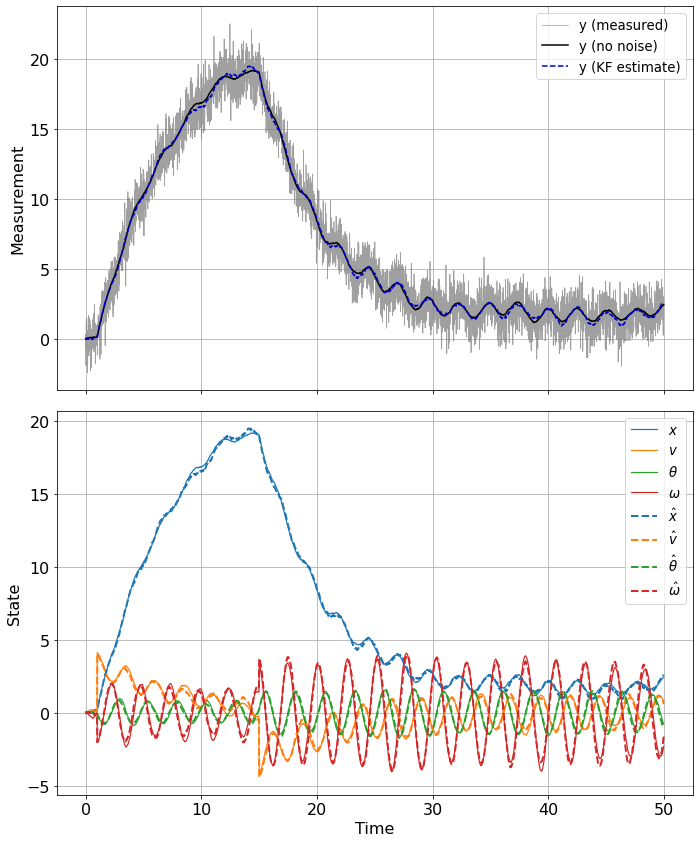

In [6]:
# Figures 8.15, 8.16

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 12))

axs[0].plot(t, y, color='grey', label='y (measured)', linewidth=0.75, alpha=0.75)
axs[0].plot(t, xtrue[:, 0], color='black', label='y (no noise)')
axs[0].plot(t, xhat[:, 0], '--', color='mediumblue', label='y (KF estimate)')
axs[0].set_ylabel('Measurement')
axs[0].legend(fontsize='small')
axs[0].grid(True)

labels = [r'$x$', r'$v$', r'$\theta$', r'$\omega$']
hat_labels = [r'$\hat{x}$', r'$\hat{v}$', r'$\hat{\theta}$', r'$\hat{\omega}$']
for i, label in enumerate(labels):
    axs[1].plot(t, xtrue[:, i], linewidth=1.2, label=label)
axs[1].set_prop_cycle(None)
for i, label in enumerate(hat_labels):
    axs[1].plot(t, xhat[:, i], '--', linewidth=2, label=label)
axs[1].set_ylabel('State')
axs[1].set_xlabel('Time')
axs[1].legend(fontsize='small')
axs[1].grid(True)

plt.tight_layout();